In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people

In [2]:
X = fetch_lfw_people(color=True, min_faces_per_person=49, funneled=False)

In [3]:
X['images'].shape

(1609, 62, 47, 3)

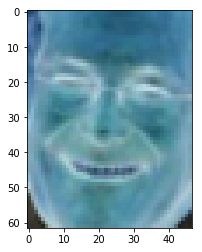

In [4]:
i=50
r = X['images'][i,:,:,0]
g = X['images'][i,:,:,1]
b = X['images'][i,:,:,2]
I = np.squeeze(X['images'][i,:,:,:])

I[:,:,0] = r
I[:,:,1] = g
I[:,:,2] = b

# plt.imshow(I)
# import matplotlib.image as mpimg
plt.imshow(I)
# plt.hist(r.ravel(),bins=20);
# plt.hist(g.ravel(),bins=20);
# plt.hist(b.ravel(),bins=20);

In [ ]:
?fetch_lfw_people

In [ ]:
X['data'].shape
plt.hist(X['data'][i,:].ravel())

In [ ]:
62*47